In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

import sys
sys.path.append("../../../../../src")

import nanonets_utils

from scipy import signal
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

plt.style.use(["science","bright"])

def load_time_series(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:].reset_index(drop=True)
            n       +=  1
    return dic

def load_states(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}mean_state_Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:].reset_index(drop=True)
            n       +=  1
    return dic

def return_best_fit(y_real_arr, y_target):
    y_target    = nanonets_utils.standard_norm(y_target)
    rmse        = []

    for i in range(y_real_arr.shape[1]):
        y_real  = y_real_arr[:,i].copy()
        y_real  = nanonets_utils.standard_norm(y_real)
        rmse.append(np.sqrt(np.sum((y_real-y_target)**2)))

    return np.argsort(rmse), rmse 

In [98]:
param   = "const"
N_th    = 36
n_p_t   = 2
N_p     = 11
t_step  = 1e-7
skip_eq = 8000
# folder  = f"/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
# folder  = f"/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
folder  = f"/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/noise/{param}/"
data    = load_time_series(folder, N_th, n_p_t, N_p, skip_eq)
t_vals  = np.arange(len(data[0]))*1e-7*1e6

In [99]:
results = pd.DataFrame(np.array([df['Current'].values*1000 for key, df in data.items()]).T)
results

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,4.402569,-32.587715,-38.795295,-1.002817,36.594031,29.572461,-37.033767,-2.618622,-2.857478,-41.396423,...,-31.041464,2.937278,35.521416,41.566167,3.637679,-37.393218,-4.539138,-2.878536,-30.719185,32.065000
1,4.402728,-32.584145,-38.798174,-0.999568,36.594695,29.577463,-37.035042,-2.615715,-2.858001,-41.390996,...,-31.042973,2.940471,35.521776,41.570343,3.637306,-37.390292,-4.539919,-2.876000,-30.720986,32.067557
2,4.404098,-32.582369,-38.799274,-0.997615,36.595456,29.580081,-37.035343,-2.613871,-2.857792,-41.388777,...,-31.043546,2.942198,35.522947,41.573023,3.637299,-37.388861,-4.540124,-2.874466,-30.721340,32.069286
3,4.404382,-32.583673,-38.799729,-0.998748,36.595855,29.578975,-37.035722,-2.613764,-2.858103,-41.391841,...,-31.043978,2.940603,35.523106,41.572223,3.637240,-37.390212,-4.541262,-2.875397,-30.721577,32.069343
4,4.399666,-32.585230,-38.804053,-0.999737,36.592505,29.577597,-37.039403,-2.613832,-2.861375,-41.394999,...,-31.047776,2.939352,35.518160,41.570986,3.633815,-37.391636,-4.545758,-2.876243,-30.726186,32.069387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,4.549489,-32.589240,-38.589682,-0.977192,36.766099,29.578805,-36.877064,-2.581487,-2.714324,-41.415279,...,-30.895138,2.935146,35.674951,41.570601,3.758731,-37.366904,-4.422999,-2.858884,-30.563394,32.076614
1995,4.551194,-32.585255,-38.588740,-0.972748,36.767763,29.583855,-36.876240,-2.578383,-2.713200,-41.408564,...,-30.894311,2.939845,35.676948,41.575987,3.759910,-37.363209,-4.421727,-2.855620,-30.562676,32.079626
1996,4.551015,-32.584752,-38.591239,-0.972118,36.768962,29.584591,-36.877407,-2.577069,-2.713539,-41.408083,...,-30.895558,2.940010,35.677217,41.577104,3.759568,-37.362879,-4.422439,-2.854996,-30.564378,32.080363
1997,4.551615,-32.586176,-38.591629,-0.973922,36.769972,29.583529,-36.877546,-2.577053,-2.713192,-41.411035,...,-30.895409,2.937845,35.677821,41.575717,3.759576,-37.364420,-4.422696,-2.855949,-30.564696,32.079769


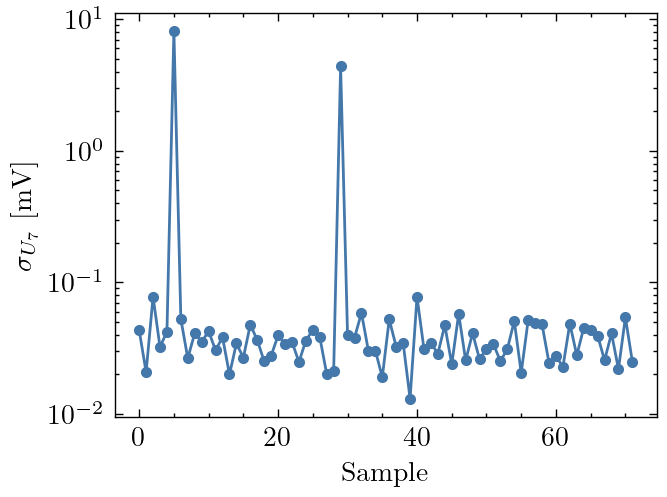

In [144]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(results.std(), '.-')

ax.set_xlabel('Sample')
ax.set_ylabel('$\sigma_{U_7}$ [mV]')
ax.set_yscale("log")

fig.savefig(f"../plots/noise/std_vs_sample.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/noise/std_vs_sample.pdf", transparent=False, bbox_inches='tight')

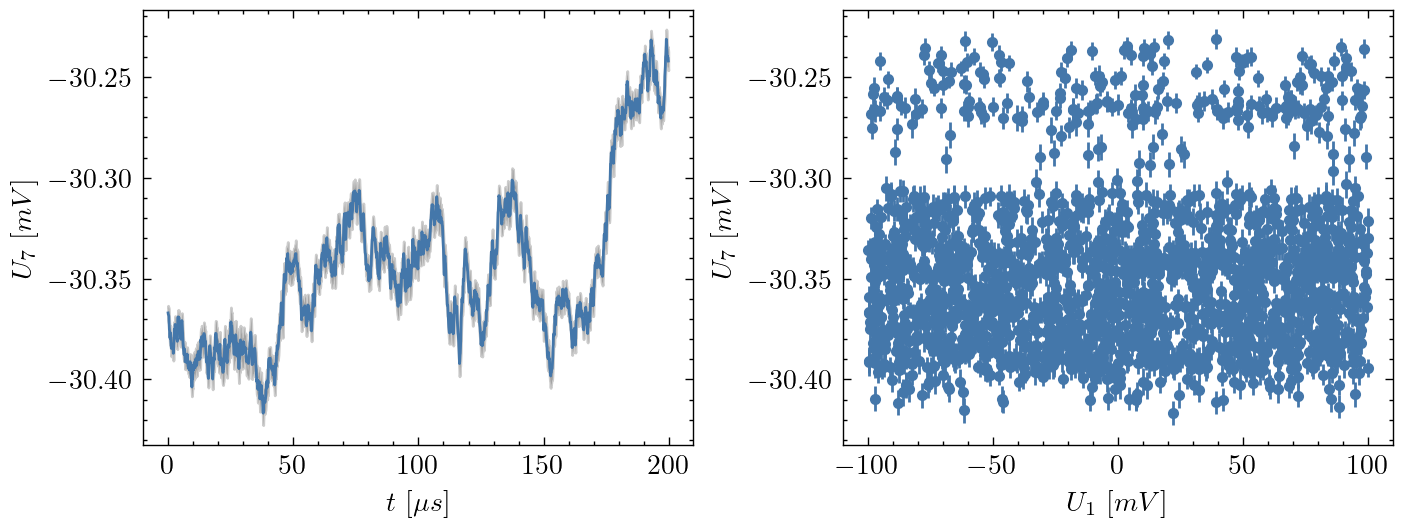

In [147]:
idx     = 30
x_val   = data[idx]['E0'].values*1000
# x_val   = data[idx].loc[:,'E0':'E6'].sum(axis=1)*1000
val     = data[idx]['Current'].values*1000
val_e   = data[idx]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, val)
ax.fill_between(t_vals, val-val_e, val+val_e, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu s$]')
ax.set_ylabel('$U_7$ [$mV$]')

ax  = fig.add_subplot(1,2,2)
ax.errorbar(x=x_val, y=val, yerr=val_e, marker='.', ls='')
ax.set_xlabel('$U_1$ [$mV$]')
ax.set_ylabel('$U_7$ [$mV$]')

fig.savefig(f"../plots/noise/output_{idx}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/noise/output_{idx}.pdf", transparent=False, bbox_inches='tight')

## Shannon Rank

In [127]:
states      = load_states(folder, N_th, n_p_t, N_p, skip_eq=skip_eq)
outputs     = np.array([df['Current'].values for _, df in data.items()]).T
output_rank = nanonets_utils.shannon_rank(outputs)
ranks       = [nanonets_utils.shannon_rank(state.values) for _, state in states.items()]

In [129]:
np.savetxt(f"data/ranks_noise_{param}.csv", ranks)

Text(0.5, 0, '$\\sum_i p_i \\cdot log(p_i)$')

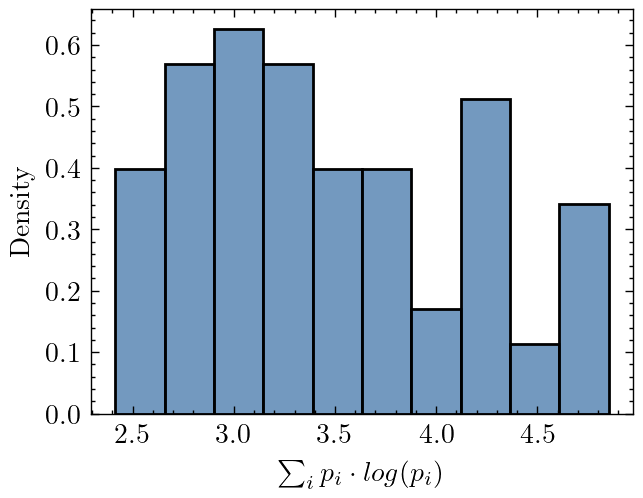

In [133]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.histplot(ranks, ax=ax, bins=10, stat='density')

ax.set_xlabel("$\sum_i p_i \cdot log(p_i)$")

---

[Text(0, 0.5, ''),
 Text(0, 6.5, ''),
 Text(0, 12.5, ''),
 Text(0, 18.5, ''),
 Text(0, 24.5, ''),
 Text(0, 30.5, ''),
 Text(0, 36.5, ''),
 Text(0, 42.5, ''),
 Text(0, 48.5, ''),
 Text(0, 54.5, ''),
 Text(0, 60.5, ''),
 Text(0, 66.5, '')]

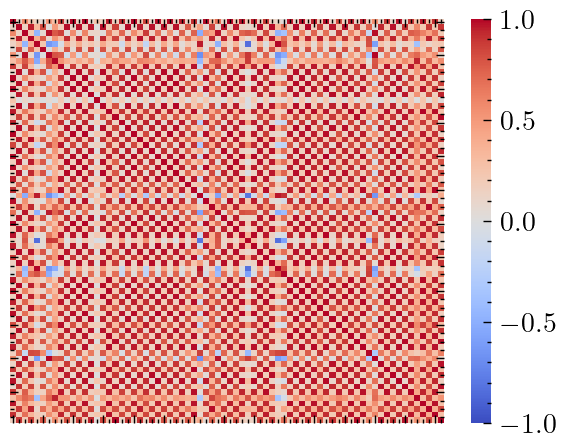

In [85]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(results.corr(), vmin=-1, vmax=1, cmap='coolwarm', ax=ax)

ax.set_xticklabels("")
ax.set_yticklabels("")